# Project Info

This is the main notebook to design the DnD Dungeon Master

Specification from Canvas:

Project Requirements

World Memory: Implement persistent storage of state for each location. The AI must recognize when players revisit a location and present an updated description reflecting prior actions.

Map Generation and Navigation: The AI should create and maintain a coherent map of connected locations, ensuring logical placement and connections.

Dynamic Descriptions and Interactions: Generate unique descriptions and manage NPC or item states dynamically, adapting based on player actions.
Randomized Location Descriptions and Encounters: When players enter a new location, the AI generates a fresh, random description consistent with nearby areas and may spawn new NPCs or items. This allows each exploration to feel novel and immersive while maintaining a coherent world.

Simplified D&D Mechanics: Use a streamlined set of D&D-inspired mechanics (detailed below) to guide the AI’s decisions and narration for combat, exploration, and interactions.

DnD Simplified Mechanics:

NPC Interaction and Combat
NPCs have two attributes: Health Points (HP) and Attack Power.
Combat: When players engage in combat, each side rolls a virtual 1d6 (a six-sided die) and adds it to their Attack Power to determine damage for that turn.

Victory Conditions: The player wins if the NPC’s HP reaches zero, and loses if their own HP does.
Skill Checks and Random Outcomes
When players attempt a risky action (e.g., unlocking a door), the AI rolls a 1d10 (a ten-sided die) for a skill check.
For simple tasks, a roll of 3 or higher succeeds.
For challenging tasks, a roll of 6 or higher is needed.
Descriptions should vary based on success or failure, giving the interaction a creative touch.

Inventory and Simple Item Use
Players can pick up and use basic items like keys or healing potions.
Items: Each item has a single effect—e.g., a potion heals 10 HP, a key unlocks a specific door.
The AI remembers which items have been used or taken to manage inventory without complex tracking.

Experience Points and Leveling (Optional)
Players can gain Experience Points (XP) for completing significant actions or defeating NPCs.
When players reach 50 XP, they "level up," gaining a small HP increase.
This provides a sense of progression with minimal complexity.

State Persistence

The AI must track and remember states for each location and NPC to maintain continuity. This includes:

Location State: Track if a door is unlocked, a chest is opened, or an item has been taken.

NPC Status: Remember if NPCs have been defeated, moved, or interacted with.

Inventory: Track items players possess and mark items as “used” once they’re applied (e.g., a used key).

Player Stats: Keep player attributes like HP, XP, and inventory status persistent across moves.


Map Representation

The map is a logical grid or node-based structure, where each “node” represents a unique location.

Location Connections: Each node includes connections to adjacent locations (e.g., north, south, east, west).

Unique Descriptions and Random Encounters: Each time players enter a new node, the AI generates a fresh description that is contextually consistent with nearby areas. The AI may also spawn random NPCs or items, creating an immersive experience while ensuring coherence.

NPC and Item Placement: Each node may contain NPCs or items, which the AI can add or remove based on player actions.

GRADUATE STUDENT:
Graduate students are required to implement additional features to expand the AI’s storytelling capabilities:

Text-to-Speech (TTS): Add a TTS system to narrate the AI-generated descriptions and interactions, enhancing the immersive experience.

Image Generation: Integrate a simple image generation model to create visual representations of locations or key events, adding a visual storytelling element to the text-based game.

# Keys and Libraries

Loading all relevant keys:

In [1]:
import os
from dotenv import load_dotenv

load_dotenv()

assert 'OPENAI_API_KEY' in os.environ, "You will need to set an OPENAI_API_KEY"
assert 'LANGCHAIN_API_KEY' in os.environ, "You will need to set an LANGCHAIN_API_KEY"

Importing all relevant libraries:

In [2]:
from langchain.agents import create_openai_functions_agent
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
#from langchain.chains import LLMMathChain
#from langchain.prompts import PromptTemplate
from langchain import hub
from langchain.agents import AgentExecutor
from langchain_core.messages import AIMessage, HumanMessage

from IPython.display import clear_output # FOR CLEAN OUTPUTS ON NOTEBOOK

from openai import OpenAI # FOR TTS

import random

# Player Class

In [3]:
class Player:
    def __init__(self, name, max_hp, xp, level):
        self.name = name
        self.max_hp = max_hp
        self.hp = max_hp
        self.xp = xp
        self.level = level
        self.inventory = []

    def take_damage(self, damage):
        self.hp -= damage
        if self.hp < 0:
            self.hp = 0

    def heal(self, amount):
        if self.has_item("Potion") or self.has_item("Health Potion") or self.has_item("Healing Potion"):
            self.hp = min(self.hp + amount, self.max_hp)
            self.remove_from_inventory("Potion")
            self.remove_from_inventory("Health Potion")
            self.remove_from_inventory("Healing Potion")
        else:
            print("You don't have a healing potion.")

    def gain_xp(self, xp):
        self.xp += xp
        if self.xp >= 100:  # Adjust the XP threshold as needed
            self.level += 1
            self.max_hp += 10  # Increase max HP with each level
            self.xp -= 100

    def add_to_inventory(self, item):
        self.inventory.append(item)

    def remove_from_inventory(self, item):
        if item in self.inventory:
            self.inventory.remove(item)

    def has_item(self, item):
        return item in self.inventory

# Initialize the player
player = Player("Adventurer", 100, 0, 1)

player.add_to_inventory("Sword")
player.add_to_inventory("Potion")

# Example usage:
# player.take_damage(20)
# print(f"Player's HP: {player.hp}")

# player.heal(30)
# print(f"Player's HP: {player.hp}")

# player.gain_xp(50)
# print(f"Player's level: {player.level}")

# print(f"Player's inventory: {player.inventory}")



# Tools

In [4]:
@tool
def rolld6() -> int:
    """ Roll a six-sided dice
    """
    rand = random.randint(1, 6)
    return rand

@tool
def rolld10() -> int:
    """ Roll a ten-sided dice
    """
    rand = random.randint(1, 10)
    return rand

@tool
def attack(attacker_power: int, defender_health: int, againstPlayer: bool) -> int:
    """ Attacker attacks the defender and check defener health
    args:
        attacker_power: power of the attack from the attacker
        defender_health: health of the defender
    """
    attacker_roll = rolld6({})
    attacker_trueap = attacker_power + attacker_roll
    if againstPlayer:
        player.take_damage(attacker_trueap)
    defender_health -= attacker_trueap
    return defender_health

@tool
def heal_player(amount: int) -> str:
    """Heals the player by the specified amount.
    Args:
        amount: The amount of health to heal.
    Returns:
        A message indicating the result of the healing.
    """
    player.heal(amount)

    if player.hp == player.max_hp:
        return f"{player.name} is fully healed. Current HP: {player.hp}" 
    else:
        return f"{player.name} healed {amount} HP. Current HP: {player.hp}"


tools = [rolld6, rolld10, attack, heal_player]

# AI Setup

In [5]:
llm = ChatOpenAI(temperature = 0, model='gpt-3.5-turbo-1106')

Prompt Template

In [6]:
prompt = hub.pull("hwchase17/openai-functions-agent")
prompt

ChatPromptTemplate(input_variables=['agent_scratchpad', 'input'], optional_variables=['chat_history'], input_types={'chat_history': list[typing.Annotated[typing.Union[typing.Annotated[langchain_core.messages.ai.AIMessage, Tag(tag='ai')], typing.Annotated[langchain_core.messages.human.HumanMessage, Tag(tag='human')], typing.Annotated[langchain_core.messages.chat.ChatMessage, Tag(tag='chat')], typing.Annotated[langchain_core.messages.system.SystemMessage, Tag(tag='system')], typing.Annotated[langchain_core.messages.function.FunctionMessage, Tag(tag='function')], typing.Annotated[langchain_core.messages.tool.ToolMessage, Tag(tag='tool')], typing.Annotated[langchain_core.messages.ai.AIMessageChunk, Tag(tag='AIMessageChunk')], typing.Annotated[langchain_core.messages.human.HumanMessageChunk, Tag(tag='HumanMessageChunk')], typing.Annotated[langchain_core.messages.chat.ChatMessageChunk, Tag(tag='ChatMessageChunk')], typing.Annotated[langchain_core.messages.system.SystemMessageChunk, Tag(tag='

Use AI Agent

In [7]:
# Create an OpenAI Functions agent
agent = create_openai_functions_agent(llm, tools, prompt=prompt)
# Create an agent executor
agent_executor = AgentExecutor.from_agent_and_tools(agent=agent,tools=tools,verbose=True, max_iteration=50, max_execution_time=50)

# TTS and Image Gen

Second AI agent to operate TTS and Image Gen

Using SimpleAudio to output audio
%pip install simpleaudio

In [8]:
from openai import OpenAI
import urllib.request 
from PIL import Image 
import simpleaudio as sa
client = OpenAI()

def GenerateImage(prompt:str):
    response = client.images.generate(
    model="dall-e-3",
    prompt=prompt,
    size="1024x1024",
    quality="standard",
    n=1,
    )
    image_url = response.data[0].url
    urllib.request.urlretrieve(image_url,"surrounding.png") 
    img = Image.open("surrounding.png") 
    display(img)

def TextToSpeech(text:str):
    response = client.audio.speech.create(
        model="tts-1",
        voice="echo", # Best voice in the sample pack
        input=text,
        response_format="wav",
        )
    response.write_to_file("output.wav")
    wave_obj = sa.WaveObject.from_wave_file("output.wav")
    play_obj = wave_obj.play()
    play_obj.wait_done()
    

# Mapping

In [9]:
import numpy as np
import random
#Create an empty map
mapsize = 5
grid = np.empty((mapsize, mapsize), dtype=object)
for i in range(mapsize):
    for j in range(mapsize):
        grid[i, j] = {"Description": "Unknown", "NPCs": [], "Items": [], "Doors": [], "Chests": []}
#Select a random starting position
currentLocation = [random.randint(0, mapsize-1), random.randint(0, mapsize-1)]

In [10]:
def generateRoom():
        #NEED TO IMPROVE PROMPTS
        #Generate Description of the room
        question = """Write a description for a room in a dnd dungeon
                example: The room is dark with stone walls and floors lit by torches on the walls
        """
        response = agent_executor.invoke({"input": question})
        grid[currentLocation[0]][currentLocation[1]]["Description"] = response["output"]
        #Generate any items
        items = random.randint(0,2)
        question = f"Generate {items} number of items for a dnd dungeon, example: key, sword, potion"
        response = agent_executor.invoke({"input": question})
        grid[currentLocation[0]][currentLocation[1]]["Items"] = response["output"]
        #Generate any NPCs
        npcs = random.randint(0,1)
        question = f"Generate {npcs} number of npcs for a dnd dungeon. examples: mysterious wizard,large skeleton "
        response = agent_executor.invoke({"input": question})
        grid[currentLocation[0]][currentLocation[1]]["NPCs"] = response["output"]

        print(grid[currentLocation[0]][currentLocation[1]])

In [11]:
 
def moveRoom(direction):
    if direction == 'North':
        currentLocation[0] = currentLocation[0] + 1
    if direction == 'South':
        currentLocation[0] = currentLocation[0] - 1
    if direction == 'East':
        currentLocation[1] = currentLocation[1] + 1
    if direction == 'West':
        currentLocation[1] = currentLocation[1] - 1
    print(grid[currentLocation])
    if grid[currentLocation[0]][currentLocation[1]]["Description"] == "Unknown":
        generateRoom()

In [12]:
from matplotlib import pyplot as plt
from matplotlib import colors
import numpy as np
def printMap():
  grid_data = np.zeros((mapsize, mapsize))  # Initialize with 0s (grey)

  for i in range(mapsize):
    for j in range(mapsize):
      if grid[i, j]["Description"] != "Unknown":
        grid_data[i, j] = 1  # Set to 1 (red) for known descriptions

  cmap = colors.ListedColormap(['gray', 'red']) # Define colormap
  plt.figure(figsize=(6, 6))
  plt.pcolor(grid_data[::1],cmap=cmap,edgecolors='k', linewidths=3)
  plt.title("Dungeon Grid")


  # Add a black circle at the current location
  plt.scatter(currentLocation[1]+0.5, currentLocation[0]+0.5, s=100, c='black', marker='o')

  plt.show()


In [ ]:
 
def moveRoom(direction):
    newX = currentLocation[0]
    newY = currentLocation[1]
    if direction == 'North':
        newX = currentLocation[0] + 1
    if direction == 'South':
        newX = currentLocation[0] - 1
    if direction == 'East':
        newY = currentLocation[1] + 1
    if direction == 'West':
        newY = currentLocation[1] - 1
    if (newX < 0 or newX >= mapsize or newY < 0 or newY >= mapsize):
        print("ERROR OUT OF BOUNDS")
    else:
        currentLocation[0] = newX
        currentLocation[1] = newY
        if grid[currentLocation[0]][currentLocation[1]]["Description"] == "Unknown":
            generateRoom()
        printMap()

Testing

In [13]:
moveRoom("West")

[[{'Description': 'Unknown', 'NPCs': [], 'Items': [], 'Doors': [], 'Chests': []}
  {'Description': 'Unknown', 'NPCs': [], 'Items': [], 'Doors': [], 'Chests': []}
  {'Description': 'Unknown', 'NPCs': [], 'Items': [], 'Doors': [], 'Chests': []}
  {'Description': 'Unknown', 'NPCs': [], 'Items': [], 'Doors': [], 'Chests': []}
  {'Description': 'Unknown', 'NPCs': [], 'Items': [], 'Doors': [], 'Chests': []}]
 [{'Description': 'Unknown', 'NPCs': [], 'Items': [], 'Doors': [], 'Chests': []}
  {'Description': 'Unknown', 'NPCs': [], 'Items': [], 'Doors': [], 'Chests': []}
  {'Description': 'Unknown', 'NPCs': [], 'Items': [], 'Doors': [], 'Chests': []}
  {'Description': 'Unknown', 'NPCs': [], 'Items': [], 'Doors': [], 'Chests': []}
  {'Description': 'Unknown', 'NPCs': [], 'Items': [], 'Doors': [], 'Chests': []}]]


> Entering new AgentExecutor chain...
The room is dimly lit with flickering torches mounted on the walls, casting dancing shadows across the stone floor. The air is musty and cool, carr

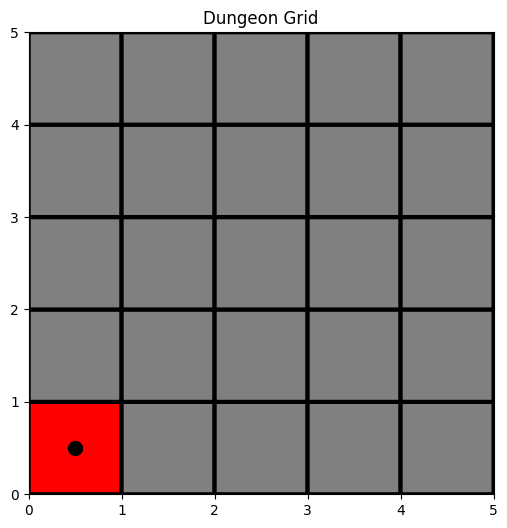

{'Description': 'The room is dimly lit with flickering torches mounted on the walls, casting dancing shadows across the stone floor. The air is musty and cool, carrying the scent of ancient stone and damp earth. The walls are adorned with faded tapestries depicting long-forgotten battles, and a sense of history and mystery lingers in the air. In the center of the room, a weathered stone altar stands, adorned with cryptic symbols and offerings long since decayed. The room exudes an aura of both reverence and foreboding, hinting at secrets waiting to be uncovered.', 'NPCs': 'I can help you generate some NPCs for your DND dungeon. How many NPCs would you like me to generate for you?', 'Items': "Sure, here's a random item for your DND dungeon: Potion of Invisibility", 'Doors': [], 'Chests': []}


In [14]:
printMap()
print(grid[currentLocation[0]][currentLocation[1]])

# Saving and Loading

In [15]:
import pickle

def save():
    with open('memory.pkl', 'wb') as file:
        pickle.dump(player, file)
        pickle.dump(grid, file)
        pickle.dump(currentLocation, file)

def load():
    with open('memory.pkl','rb') as file:
        player = pickle.load(file)
        grid = pickle.load(file)
        currentLocation = pickle.load(file)

# Main Code

1. Define chat_history and generally used methods (GetContext and PrompAndResponse)
2. Define initial generation of game state

In [23]:
chat_history = []
def GetContext(theme:str, character:str):
    opening_prompt = """You are a DnD Dungeon Master. 
    You will run a simplified DnD games with given tools for different scenarios.
    If the player runs into a scenario that requires skill check, the player will roll a d10.
    If the scenario is easy to resolve, they will need 3 or higher.
    If the scenario is hard to resolve, they will need 7 or higher.
    If the player runs into combat, use the attack tool to operate through combat scenario 
    where each side (player vs npc) alternate turn to attack until one dies.
    You will write a story according to the following theme: {}.
    My character is {}""".format(theme, character)
    return opening_prompt

def PromptAndResponse(question:str, image:bool = True, audio:bool = True):
    response = agent_executor.invoke({
        "input" : question,
        "chat_history": chat_history,
    })  
    chat_history.append(HumanMessage(content=question))
    chat_history.append(AIMessage(content=response['output']))

    print(f"Your input: {question}")
    if (image):
        imageContext = agent_executor.invoke({
            "input" : "Describe the surrounding in one sentence",
            "chat_history" : chat_history,
        })
        GenerateImage(imageContext['output'])

    print(f"Dungeon Master: {response['output']}")

    if (audio):
        TextToSpeech(response['output'])
    

# Method to get starting prompt and initialize the game
def StartGame():
    #theme = input()
    #print("Please enter your character:")
    #USE TO START THE GAME PROPE
    #Create an empty map
    mapsize = 5
    grid = np.empty((mapsize, mapsize), dtype=object)
    for i in range(mapsize):
        for j in range(mapsize):
            grid[i, j] = {"Description": "Unknown", "NPCs": [], "Items": [], "Doors": [], "Chests": []}
    # Define Player Information
    player = {"Inventory":[], "Health":100, "XP":0, "Attack_Power":10}
    #Select a random starting position
    currentLocation = [random.randint(0, mapsize-1), random.randint(0, mapsize-1)]
    #Check if save exists
    if os.path.exists("memory.pkl"):
        load()
    else:
        chat_history = []
        print("Welcome to Dungeon Intelligence. Please enter the theme of the game:")
        theme = input()
        print("Please enter your character:")
        character = input()
        player['Name'] = character
        chat_history.append(GetContext(theme, character))
        PromptAndResponse("Can you start the game with the given information?")
    

3. Define game loop and end condition. The game ends on pressing Esc

In [ ]:
import os

def Cleanup():
    if (os.path.exists("output.wav")):
        os.remove("output.wav")
    if (os.path.exists("surrounding.png")):
        os.remove("surrounding.png")

# Method to play the game and enter game loop
def PlayGame():
    playing = True

    while(playing):
        question = input()
        clear_output()

        if (len(question) < 1):
            playing = False
            question = "I am done with the game. Thank you."
            PromptAndResponse(question, False, False) # Only generate audio and reduce the load time when ending
            Cleanup()
        else:
            PromptAndResponse(question)
    save()

Actual Run code:

In [25]:
StartGame()
PlayGame()



> Entering new AgentExecutor chain...
You're welcome! If you ever want to continue the game or explore more adventures, feel free to ask. Have a great day!

> Finished chain.
Your input: I am done with the game. Thank you.
Dungeon Master: You're welcome! If you ever want to continue the game or explore more adventures, feel free to ask. Have a great day!
